In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.stats import poisson
from scipy.stats import skellam

In [2]:
# crime_data = pd.read_excel('C:/Users/michelj8/Documents/GitHub/expo_smooth_lasso/integer_valued_ts/crime_480_data.xlsx')
crime_data = pd.read_excel('C:/Users/michelj8/Documents/GitHub/integer_valued_ts/crime_480_data.xlsx')
# "C:\Users\michelj8\Documents\GitHub\z-values-series\crime_230_data.xlsx"
# "C:\Users\michelj8\Documents\GitHub\expo_smooth_lasso\integer_valued_ts\crime_888_data.xlsx"

In [3]:
crime_data.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,191506964,2019-02-25,2019-02-25,2325,15,N Hollywood,1557,1,480,BIKE - STOLEN,...,IC,Invest Cont,480,NaN,NaN,NaN,5000 CARTWRIGHT AV,NaN,34.1613,-118.3637
1,190128566,2019-12-05,2019-12-04,2230,1,Central,152,1,480,BIKE - STOLEN,...,IC,Invest Cont,480,NaN,NaN,NaN,7TH,FLOWER ST,34.0487,-118.2588
2,190615415,2019-07-13,2019-07-13,1830,6,Hollywood,666,1,480,BIKE - STOLEN,...,IC,Invest Cont,480,NaN,NaN,NaN,6300 W SUNSET BL,NaN,34.0980,-118.3267
3,190606178,2019-01-30,2019-01-01,1050,6,Hollywood,669,1,480,BIKE - STOLEN,...,IC,Invest Cont,480,NaN,NaN,NaN,5300 LEXINGTON AV,NaN,34.0930,-118.3046
4,190104755,2019-01-12,2019-01-09,2200,1,Central,158,1,480,BIKE - STOLEN,...,IC,Invest Cont,480,NaN,NaN,NaN,800 E 6TH ST,NaN,34.0408,-118.2428


In [4]:
crime_data['Crm Cd Desc'].unique()

array(['BIKE - STOLEN'], dtype=object)

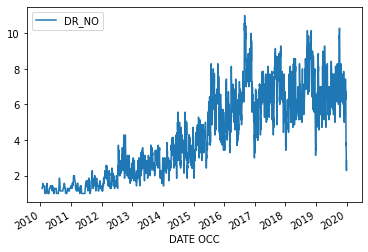

In [5]:
crime_data.groupby(['DATE OCC']).count()[['DR_NO']].rolling(window = 7).mean().plot()

In [6]:
ts_df = crime_data.groupby(['DATE OCC']).count()[['DR_NO']].reset_index()
ts_df['year-month'] = ts_df['DATE OCC'].apply(lambda s: str(s)[0:7])

ts_df = ts_df.groupby('year-month').sum()
ts_df.columns = ['Y']

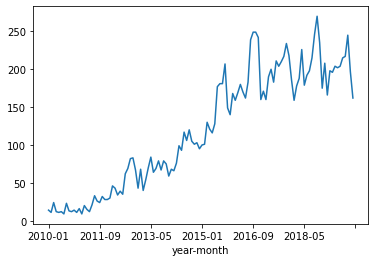

In [7]:
ts_df['Y'].plot()

In [8]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_df, (1,0)).fit()
model.params

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


const      109.768996
ar.L1.Y      0.964033
dtype: float64

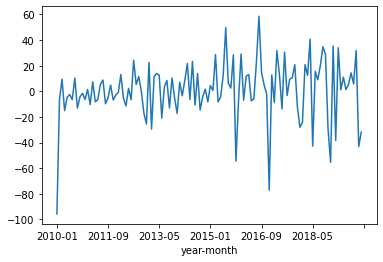

In [9]:
model.resid.plot()

# Add in transformations and plots

In [10]:
ts_df['delta'] = ts_df['Y'].diff(1)
ts_df['abs_delta'] = np.abs(ts_df['delta'])

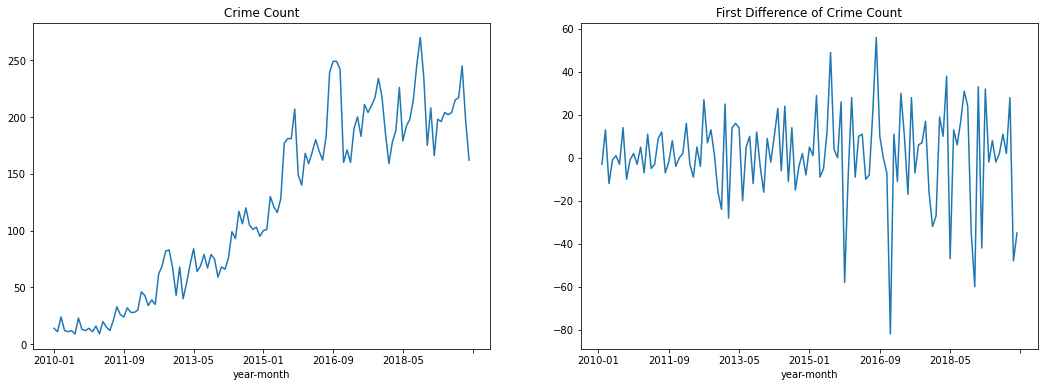

In [11]:
fig, ax  = plt.subplots(1,2, figsize = (18,6))

ts_df['Y'].plot(ax = ax[0], title = 'Crime Count')
ts_df['delta'].plot(ax = ax[1], title = 'First Difference of Crime Count')

In [12]:
ts_df['delta'].describe()

count    119.000000
mean       1.243697
std       20.946650
min      -82.000000
25%       -7.500000
50%        2.000000
75%       12.500000
max       56.000000
Name: delta, dtype: float64

In [13]:
rolling_summary_df = pd.DataFrame(columns = ['mean','var','abs','sign'])

rolling_summary_df['mean'] = ts_df['delta'].rolling(window = 12).mean()
rolling_summary_df['var'] = np.square(ts_df['delta'].rolling(window = 12).std())
rolling_summary_df['abs'] = np.abs(ts_df['delta']).rolling(window = 12).mean()
rolling_summary_df['sign'] = np.sign(ts_df['delta']).rolling(window = 12).mean()

C:\Users\michelj8\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


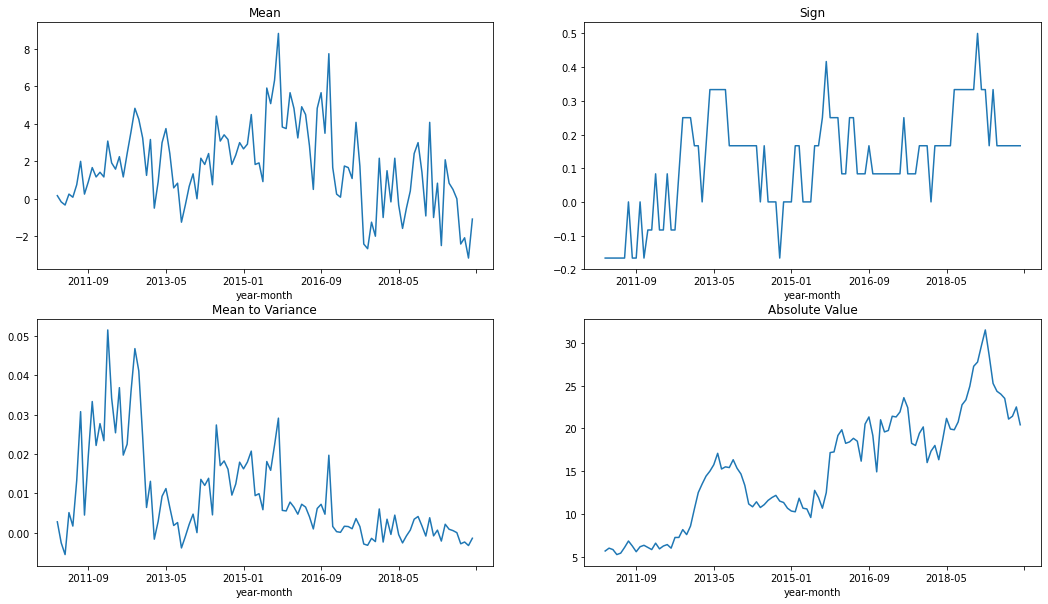

In [14]:
fig, ax = plt.subplots(2,2, figsize = (18,10))

rolling_summary_df['mean'].plot(ax = ax[0][0], title = 'Mean')
# rolling_summary_df['var'].plot(ax = ax[1][0], title = 'Variance')
(rolling_summary_df['mean']/rolling_summary_df['var']).plot(ax = ax[1][0], title = 'Mean to Variance')
rolling_summary_df['sign'].plot(ax = ax[0][1], title = 'Sign')
rolling_summary_df['abs'].plot(ax = ax[1][1], title = 'Absolute Value')

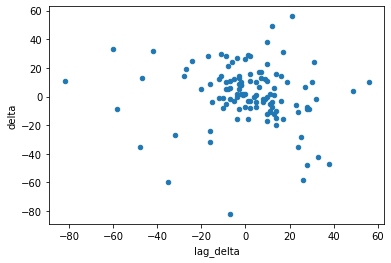

In [15]:
ts_df['lag_delta'] = ts_df['delta'].shift(1)
ts_df['abs_delta'] = np.abs(ts_df['delta'])
ts_df.plot.scatter(x='lag_delta',y='delta')

In [16]:
from statsmodels.tsa.stattools import acf, pacf
acf(ts_df['delta'].dropna())

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


array([ 1.        , -0.12523434, -0.02143841, -0.14209078, -0.22022475,
       -0.03075918,  0.05838239,  0.17418154, -0.23826606, -0.08016097,
       -0.08057162,  0.07644729,  0.27656177,  0.27822527, -0.10010017,
       -0.00982147, -0.23516118, -0.05011073,  0.07243819,  0.03689744,
       -0.08199421, -0.13293368, -0.08175125,  0.07767422,  0.29060687,
       -0.03195789,  0.16375494, -0.07587524, -0.13703773, -0.02391245,
        0.0119034 ,  0.00581892, -0.12545412,  0.03851128, -0.14494272,
        0.00146153,  0.32193605,  0.05639019, -0.04097233,  0.07299143,
       -0.20617797])

const          1.282236
ar.L1.delta   -0.127476
dtype: float64


C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


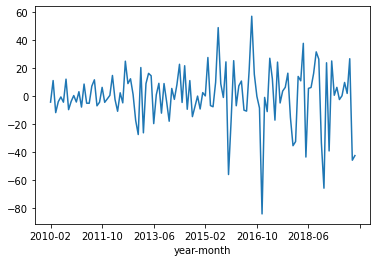

In [17]:
model = ARMA(ts_df['delta'].dropna(), (1,0)).fit()
print(model.params)
model.resid.plot()

const              15.065194
ar.L1.abs_delta     0.259566
dtype: float64


C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


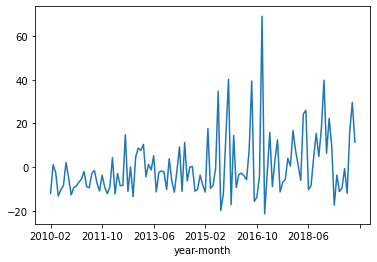

In [18]:
model = ARMA(ts_df['abs_delta'].dropna(), (1,0)).fit()
print(model.params)
model.resid.plot()

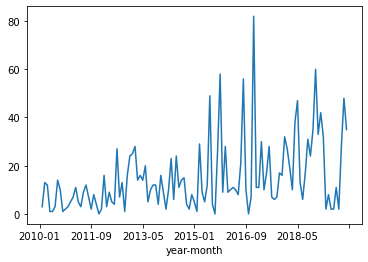

In [19]:
ts_df['abs_delta'].plot()

In [20]:
ts_df['delta_lag'] = ts_df['delta'].shift(1)

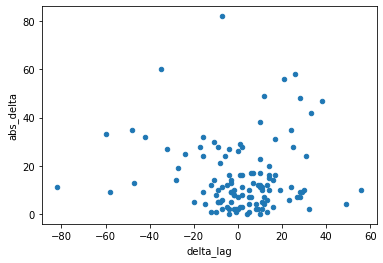

In [21]:
ts_df.plot.scatter(x='delta_lag' ,y='abs_delta')

# Estimation

## Time trend AR-Poisson

In [22]:
def tt_ar_pois(gamma,omega,alpha,beta,ts):
    sample_size = len(ts)
    ll_value = 0
    mean_est = ts[0]
    inf_status = 0
    
    for r in range(1,sample_size):
        new_y = ts[r]
#         ll_value = -1*np.log( poisson.pmf(new_y ,mean_est) )
        obs_ll_value = poisson.pmf(new_y,mean_est)
        ll_value = ll_value + obs_ll_value
        mean_est = gamma*r + omega + alpha*new_y + beta*mean_est
        
        if obs_ll_value < -100:
            inf_status =1
            
    if inf_status == 1:
        return 10000
    
    if inf_status == 0:
        return -ll_value

In [23]:
def tt_ar_pois_filter(gamma,omega,alpha,beta,ts):
    sample_size = len(ts)
    mean_est = [ts[0]]
    
    for r in range(1, sample_size):
        new_y = ts[r]
        new_mean_est = gamma*r + omega + alpha*new_y + beta*mean_est[-1]
        mean_est.append(new_mean_est)
        
    filter_df = pd.DataFrame({'Y':ts,'mean_est':mean_est})
    filter_df['mean_est'] = filter_df['mean_est'].shift(1)
    filter_df = filter_df.dropna()
    return filter_df

In [26]:
level_series = ts_df['Y'].dropna()

initial_guess = [1,1,.1,.2]
guess = initial_guess.copy()

for iteration in range(0,10):
    res_g = minimize_scalar( lambda g_hat : tt_ar_pois(g_hat, guess[1], guess[2], guess[3],level_series ), bounds = (.01,3), method = 'bounded')
    guess[0] = res_g.x

    res_o = minimize_scalar( lambda o_hat : tt_ar_pois(guess[0], o_hat, guess[2], guess[3],level_series ), bounds = (.01,3),  method = 'bounded')
    guess[1] = res_o.x

    res_a = minimize_scalar( lambda a_hat : tt_ar_pois(guess[0], guess[1], a_hat, guess[2],level_series ), bounds = (0,1), method = 'bounded')
    guess[2] = res_a.x

    res_b = minimize_scalar( lambda b_hat : tt_ar_pois(guess[0], guess[1], guess[2], b_hat,level_series ), bounds = (0, 1) , method = 'bounded')
    guess[3] = res_b.x

tt_ar_guess = guess
guess

[1.1570678098277747,
 0.01000347428866272,
 0.12493382444777035,
 0.24390467715008124]

In [27]:
res_fill = minimize( lambda s: tt_ar_pois(s[0],s[1],s[2],s[3],level_series  ) , x0 = tt_ar_guess ,  method='Nelder-Mead' )
tt_ar_mle = res_fill.x

tt_ar_mle

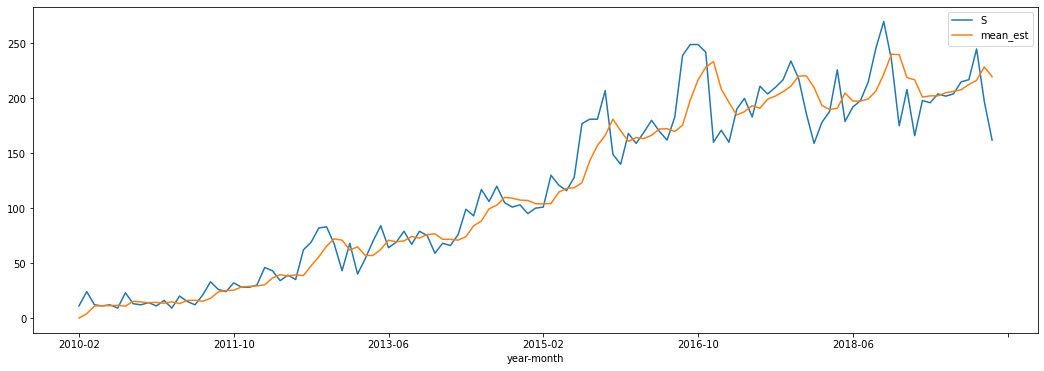

In [29]:
gamma,omega,alpha,beta  = tt_ar_mle
mle_df = tt_ar_pois_filter(gamma,omega,alpha,beta,Y)

fig, ax = plt.subplots(figsize = (18,6))
mle_df.plot(ax =ax)
ax.legend(['S','mean_est'])

0.3025210084033613

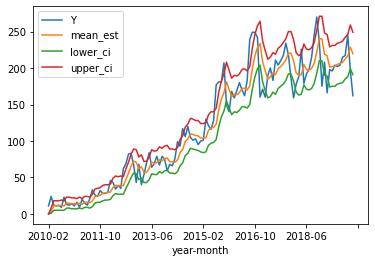

In [30]:
ci_alpha = .95

for index in mle_df.index:
    ci = poisson.interval(ci_alpha, mle_df.loc[index,'mean_est'])
    mle_df.loc[index,'lower_ci'] = ci[0]
    mle_df.loc[index,'upper_ci'] = ci[1]
    
mle_df.plot()
len(mle_df.query('Y < lower_ci | Y > upper_ci'))/len(mle_df)

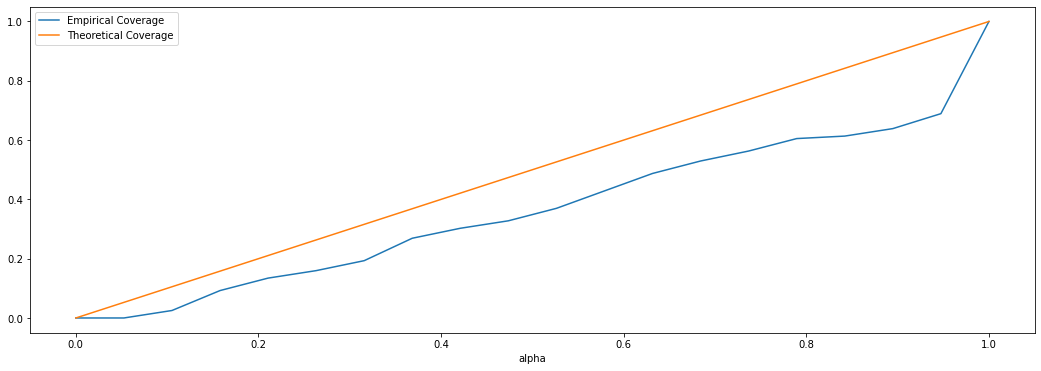

In [31]:
ci_cover_df = pd.DataFrame(columns = ['alpha','tt_ar_actual_coverage']).set_index('alpha')
grid_size = 20
fig, ax = plt.subplots(figsize = (18,6))


for ci_alpha in np.linspace(0,1,grid_size):
    for index in mle_df.index:
        ci = poisson.interval(ci_alpha, mle_df.loc[index,'mean_est'])
        mle_df.loc[index,'lower_ci'] = ci[0]
        mle_df.loc[index,'upper_ci'] = ci[1]
        
    ci_cover_df.loc[ci_alpha, 'tt_ar_actual_coverage'] = len(mle_df.query('Y > lower_ci & Y < upper_ci'))/len(mle_df)
    
ci_cover_df['Theoretical_Coverage'] = np.linspace(0,1,grid_size)
ci_cover_df.plot(ax = ax)
ax.legend(['Empirical Coverage','Theoretical Coverage'])

## Skellam Estimation

In [24]:
def censor(val,lower_bound, upper_bound):
    return min( max(val,lower_bound), upper_bound)

In [25]:
def skellam_ar(o,a,b,r,ts):
    sample_size = len(ts)
    
    ll_value = 0
    mean_est = ts[0]
    
    inf_status = 0
    
    for time in range(1,sample_size):
        state_var = abs(mean_est/2.0) * (r + np.sign(mean_est)*np.array([1,-1]))
        new_y = censor(ts[time], -30,30)
        
        obs_ll_value = np.log( skellam(state_var[0],state_var[1]).pmf(new_y) )
        ll_value = ll_value + obs_ll_value
        mean_est =  o + a*new_y + b*mean_est
        
        if obs_ll_value < -200:
            inf_status =1
            
    if inf_status == 1:
        return 10000
    
    if inf_status == 0:
        return -ll_value

In [27]:
def skellam_filter(c,a,b,r,ts):
    sample_size = len(ts)

    mu_est = [ts[0]]
    for time in range(1,sample_size):
        new_mu_est = c+a*ts[time] + b*mu_est[-1]
        mu_est.append(new_mu_est)
    
    filter_df = pd.DataFrame({'obs':ts, 'mu_est':mu_est})
    filter_df['mu_est'] = filter_df['mu_est'].shift(1)
    filter_df = filter_df.dropna()
    
    filter_df['state1'] = filter_df['mu_est'].apply(lambda s: abs(s/2)*( r + np.sign(s)) )
    filter_df['state2'] =filter_df['mu_est'].apply(lambda s: abs(s/2)*( r - np.sign(s)) )
    
    return filter_df

In [36]:
delta_series = ts_df['delta'].dropna()

initial_guess = [0.5,.5,.2, 50.0]
guess = initial_guess.copy()

for iteration in range(0,5):
    res_o = minimize_scalar( lambda o_hat : skellam_ar(o_hat, guess[1], guess[2], guess[3], delta_series ), bounds = (-2,2),  method = 'bounded')
    guess[0] = res_o.x

    res_a = minimize_scalar( lambda a_hat : skellam_ar(guess[0],a_hat, guess[2], guess[3],  delta_series ), bounds = (0,1-guess[2]), method = 'bounded')
    guess[1] = res_a.x

    res_b = minimize_scalar( lambda b_hat : skellam_ar(guess[0], guess[1], b_hat, guess[3], delta_series ), bounds = (0, 1-guess[1]) , method = 'bounded')
    guess[2] = res_b.x
    
#     res_r = minimize_scalar( lambda r_hat : skellam_ar(guess[0], guess[1], guess[2], r_hat , Y ), bounds = (1.5,5), method = 'bounded')
#     guess[3] = res_r.x


skellam_guess = guess
guess

[-0.4721359549995796, 0.2764064236422914, 0.2763881521275523, 100.0]

In [38]:
# res_fill = minimize( lambda s: skellam_ar(s[0],s[1],s[2],skellam_guess[3] , delta_series  ) , x0 = skellam_guess ,  method='Nelder-Mead' )
res_fill = minimize( lambda s: skellam_ar(s[0],s[1],s[2],s[3] , delta_series  ) , x0 = skellam_guess ,  method='Nelder-Mead' )
skellam_mle = res_fill.x

skellam_mle

array([ -0.47213595,   0.27640642,   0.27638815, 100.        ])

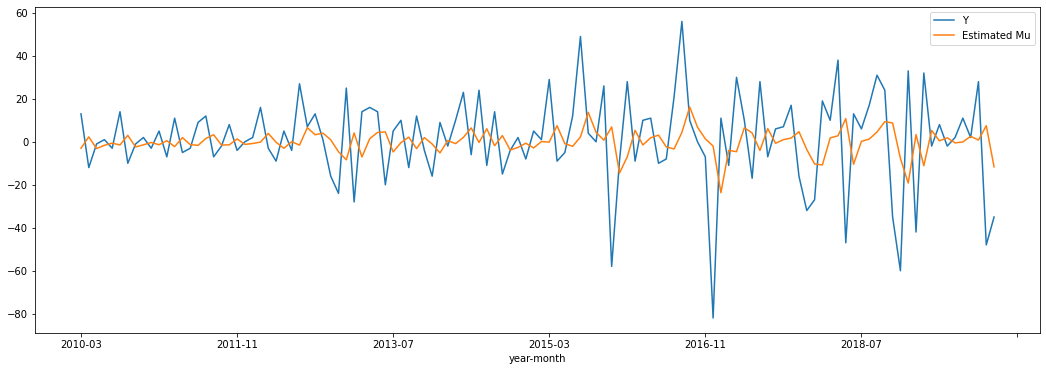

In [39]:
c,a,b,r = skellam_mle

fig, ax = plt.subplots(figsize = (18,6))

mle_df = skellam_filter(c,a,b,r,delta_series) 
mle_df[['obs','mu_est']].plot(ax = ax)
ax.legend(['Y','Estimated Mu'])

0.22033898305084745

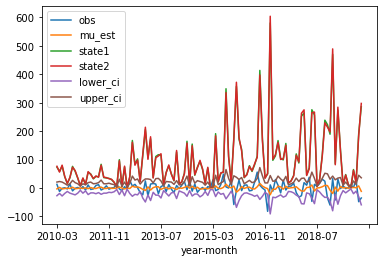

In [41]:
ci_alpha = .95

for index in mle_df.index:
    ci = skellam(mle_df.loc[index, 'state1'], mle_df.loc[index,'state2']).interval(ci_alpha)
    mle_df.loc[index,'lower_ci'] = ci[0]
    mle_df.loc[index,'upper_ci'] = ci[1]
    
mle_df.plot()
len(mle_df.query('obs < lower_ci | obs > upper_ci'))/len(mle_df)

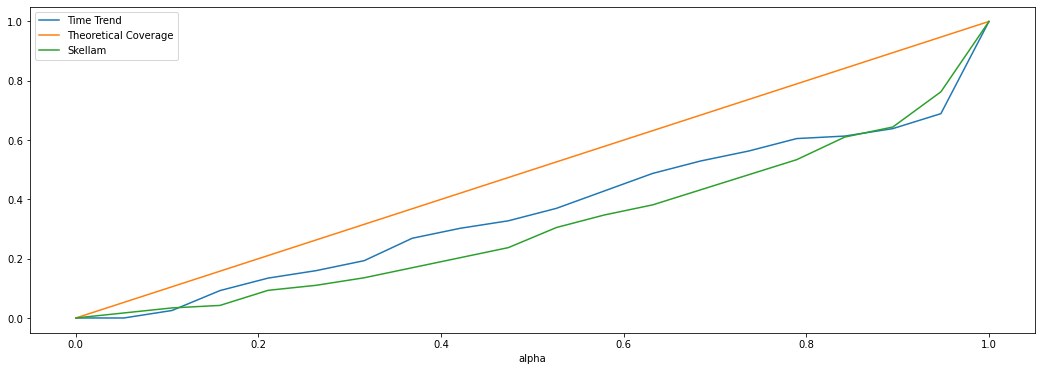

In [44]:
# ci_cover_df = pd.DataFrame(columns = ['alpha','actual_coverage']).set_index('alpha')
# grid_size = 20
fig, ax = plt.subplots(figsize = (18,6))


for ci_alpha in np.linspace(0,1,grid_size):
    for index in mle_df.index:
        ci = skellam(mle_df.loc[index, 'state1'], mle_df.loc[index,'state2']).interval(ci_alpha)
        mle_df.loc[index,'lower_ci'] = ci[0]
        mle_df.loc[index,'upper_ci'] = ci[1]
        
    ci_cover_df.loc[ci_alpha, 'skellam_actual_coverage'] = len(mle_df.query('obs > lower_ci & obs < upper_ci'))/len(mle_df)
    
ci_cover_df['Theoretical_Coverage'] = np.linspace(0,1,grid_size)
ci_cover_df.plot(ax = ax)
ax.legend(['Time Trend','Theoretical Coverage', 'Skellam'])

## Signed Autoregressive Poissons

In [28]:
def signed_pmf(k, lam, prob):
    return (prob*(k>=0) + (1-prob)*(k <= 0))*poisson.pmf(abs(k),lam)

In [29]:
def signed_ar_ci(lam, prob, alpha):
    if alpha > .9999:
        return [-10000,10000]
    else:
        upper = round(lam*(2*prob-1))
        lower = round(lam*(2*prob-1))

        total_prob = signed_pmf(upper, lam ,prob)

        while total_prob < alpha:
            lower = lower - 1
            upper = upper + 1

            total_prob = total_prob + signed_pmf(upper, lam, prob) + signed_pmf(lower, lam,prob)

        return [lower,upper]

In [30]:
def asym_signed_ar_ci(lam, prob, alpha):
    upper = round(lam*(2*prob-1))
    lower = round(lam*(2*prob-1))

    total_prob = signed_pmf(upper, lam ,prob)

    candidate_upper = upper +1
    candidate_lower = lower-1

    cand_up_prob = signed_pmf(candidate_upper, lam, prob)
    cand_lower_prob = signed_pmf(candidate_lower, lam, prob)

    while total_prob < alpha:
        print(lower, upper)
        if cand_up_prob >= cand_lower_prob:
            upper = candidate_upper
            total_prob = total_prob + cand_up_prob

            candidate_upper = upper +1
            cand_up_prob = signed_pmf(candidate_upper, lam, prob)


        if cand_up_prob < cand_lower_prob:
            lower = candidate_lower
            total_prob = total_prob + cand_lower_prob

            candidate_lower = lower -1
            cand_low_prob = signed_pmf(candidate_lower, lam, prob)


    return [lower,upper]

### Fixed variance, model mu

In [31]:
def signed_ar_fix_var(o,a,b,sigsq,ts):
    sample_size = len(ts)
    
    ll_value = 0
    mean_est = ts[0]
    
    inf_status = 0
    
    for r in range(1,sample_size):
        new_y = ts[r]
        lam_state = .5*(-1 + np.sqrt(1+4*sigsq+4*np.square(mean_est) ) )
        prob_state = .5*(1+(mean_est/lam_state))
        
        obs_ll_value = np.log( signed_pmf(new_y, lam_state , prob_state)  )
        ll_value = ll_value + obs_ll_value
        mean_est =  o + a*new_y + b*mean_est
        
        if obs_ll_value < -200:
            inf_status =1
            
    if inf_status == 1:
        return 10000
    
    if inf_status == 0:
        return -ll_value

In [32]:
def signed_ar_fix_var_filter(o,a,b,sigsq,ts):
    sample_size = len(ts)
    
    mean_est = [ ts[0] ]
    lam_est = [.5*(-1 + np.sqrt(1+4*sigsq+4*np.square(mean_est[0]) ) ) ]
    prob_est = [ .5*(1+(mean_est[0]/lam_est[0])) ]
    
    for r in range(1, sample_size):
        new_y = ts[r]
        
        new_mean = o + a*new_y + b*mean_est[-1]
        new_lam = .5*(-1 + np.sqrt(1+4*sigsq+4*np.square(new_mean) ) )
        new_prob = .5*(1+(new_mean/new_lam))
        
        mean_est.append(new_mean)
        lam_est.append(new_lam)
        prob_est.append(new_prob)
        
    filter_df = pd.DataFrame({'Y':ts,'mean':mean_est,'lam':lam_est,'prob':prob_est})
    filter_df[['mean','lam','prob']] =filter_df[['mean','lam','prob']].shift(1)
    filter_df = filter_df.dropna()
    return filter_df

In [51]:
# Y = ts_df['delta'].dropna()

# signed_ar_fix_var(1.2,.1,0,400,Y)

1086.71816690913

In [52]:
delta_series = ts_df['delta'].dropna()

initial_guess = [1.2,.1,0,200]
guess = initial_guess.copy()

for iteration in range(0,15):
    res_o = minimize_scalar( lambda o_hat : signed_ar_fix_var(o_hat, guess[1], guess[2], guess[3], delta_series ), bounds = (-2,2),  method = 'bounded')
    guess[0] = res_o.x

    res_a = minimize_scalar( lambda a_hat : signed_ar_fix_var(guess[0],a_hat, guess[2], guess[3],  delta_series ), bounds = (0,1-guess[2]), method = 'bounded')
    guess[1] = res_a.x

    res_b = minimize_scalar( lambda b_hat : signed_ar_fix_var(guess[0], guess[1], b_hat, guess[3], delta_series ), bounds = (0, 1-guess[1]) , method = 'bounded')
    guess[2] = res_b.x
    
#     res_r = minimize_scalar( lambda r_hat : skellam_ar(guess[0], guess[1], guess[2], r_hat , Y ), bounds = (1.5,5), method = 'bounded')
#     guess[3] = res_r.x


signed_ar_guess = guess
guess

[0.1338556001198613, 0.376270672621039, 0.03281589354524978, 200]

In [53]:
res_fill = minimize( lambda s: signed_ar_fix_var(s[0],s[1],s[2], signed_ar_guess[3] , delta_series  ) , x0 = signed_ar_guess ,  method='Nelder-Mead' )
signed_ar_mle = res_fill.x

signed_ar_mle

array([1.33856111e-01, 3.76270337e-01, 3.28158482e-02, 2.04061135e+02])

In [54]:
o,a,b,sigsq = signed_ar_mle

mle_df = signed_ar_fix_var_filter(o,a,b,sigsq,delta_series)

0.7796610169491526

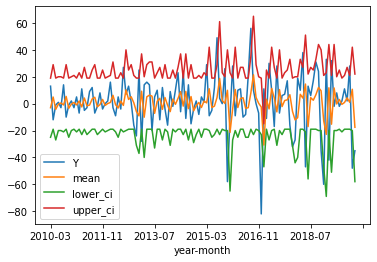

In [55]:
mle_df['lower_ci'] = mle_df.apply(lambda s: signed_ar_ci(s[2],s[3], .95 )[0]  , axis =1)
mle_df['upper_ci'] = mle_df.apply(lambda s: signed_ar_ci(s[2],s[3], .95 )[1]  , axis =1)

mle_df[['Y','mean','lower_ci','upper_ci']].plot()
len(mle_df.query('Y > lower_ci & Y < upper_ci'))/len(mle_df)

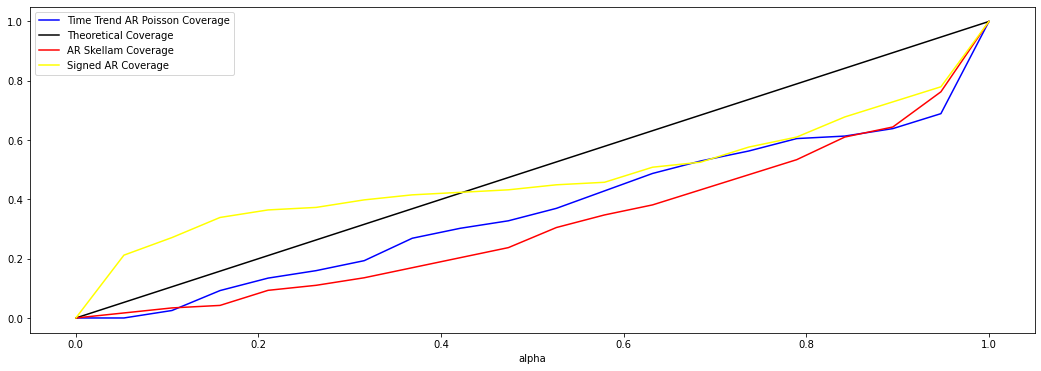

In [118]:
# ci_cover_df = pd.DataFrame(columns = ['alpha','actual_coverage']).set_index('alpha')
# grid_size = 20
fig, ax = plt.subplots(figsize = (18,6))


for ci_alpha in np.linspace(0,1,grid_size):
    mle_df['lower_ci'] = mle_df.apply(lambda s: signed_ar_ci(s[2],s[3], ci_alpha )[0]  , axis =1)
    mle_df['upper_ci'] = mle_df.apply(lambda s: signed_ar_ci(s[2],s[3], ci_alpha )[1]  , axis =1)

        
    ci_cover_df.loc[ci_alpha, 'signed_ar_actual_coverage'] = len(mle_df.query('Y > lower_ci & Y < upper_ci'))/len(mle_df)
    
ci_cover_df['Theoretical_Coverage'] = np.linspace(0,1,grid_size)
ci_cover_df.plot(ax = ax,  color = ['blue', 'black', 'red', 'yellow'])
ax.legend(['Time Trend AR Poisson Coverage','Theoretical Coverage', 'AR Skellam Coverage','Signed AR Coverage'])

# Study the Prediction Intervals for the MLE more:

In [33]:
level_series = ts_df['Y'].dropna()
delta_series = ts_df['delta'].dropna()

tt_ar_mle = [1.1570678098277747, 0.01000347428866272, 0.12493382444777035, 0.24390467715008124]
gamma,omega,alpha,beta  = tt_ar_mle
tt_mle_df = tt_ar_pois_filter(gamma,omega,alpha,beta,level_series)

skellam_mle = [ -0.47213595,   0.27640642,   0.27638815, 50.0        ]
c,a,b,r = skellam_mle
skellam_mle_df = skellam_filter(c,a,b,r,delta_series) 

signed_ar_mle = [1.33856111e-01, 3.76270337e-01, 3.28158482e-02, 2.04061135e+02]
o,a,b,sigsq = signed_ar_mle
signed_mle_df = signed_ar_fix_var_filter(o,a,b,sigsq,delta_series)

## Point forecast accuracy

In [34]:
forecast_df = pd.DataFrame(columns = ['k']).set_index('k')

In [35]:
#k step ahead point forecasts for the AR with time trend
tt_mle_df['time_count'] = range(0, len(tt_mle_df))
tt_pushforward_est = tt_mle_df[['mean_est','time_count']].copy()
    
forecast_df.loc[1,'tt_mse'] = np.square(tt_mle_df['Y']-tt_pushforward_est['mean_est']).mean()
forecast_df.loc[1,'tt_bias'] = (tt_mle_df['Y']-tt_pushforward_est['mean_est']).mean()
forecast_df.loc[1,'tt_var'] = np.square( (tt_mle_df['Y']-tt_pushforward_est['mean_est']).std() )


for k in range(1,10):
    tt_pushforward_est['mean_est'] = tt_pushforward_est.apply(lambda s: tt_ar_mle[0]*s[1] + tt_ar_mle[1]+(tt_ar_mle[2]+tt_ar_mle[3])*s[0], axis=1 ).shift(1)

    forecast_df.loc[k+1,'tt_mse'] = np.square(tt_mle_df['Y'] - tt_pushforward_est['mean_est']).mean()
    forecast_df.loc[k+1,'tt_bias'] = (tt_mle_df['Y'] - tt_pushforward_est['mean_est']).mean()
    forecast_df.loc[k+1,'tt_var'] = np.square( (tt_mle_df['Y']-tt_pushforward_est['mean_est']).std() )


In [36]:
#k step ahead point forecasts for the skellam
skellam_pushforward_est = skellam_mle_df[['mu_est']].copy()

forecast_df.loc[1,'skel_mse'] = np.square(skellam_mle_df['obs']-skellam_pushforward_est['mu_est']).mean()
forecast_df.loc[1,'skel_bias'] = (skellam_mle_df['obs']-skellam_pushforward_est['mu_est']).mean()
forecast_df.loc[1,'skel_var'] = np.square( (skellam_mle_df['obs']- skellam_pushforward_est['mu_est']).std() )



for k in range (1,10):
    skellam_pushforward_est['mu_est'] = skellam_pushforward_est['mu_est'].apply(lambda s: skellam_mle[0] + (skellam_mle[1]+skellam_mle[2])*s ).shift(1)
    skellam_k_error_df = (skellam_mle_df['obs'] - skellam_pushforward_est['mu_est']).rolling(window = k+1).sum()

    forecast_df.loc[k+1,'skel_mse'] = np.square(skellam_k_error_df).mean()
    forecast_df.loc[k+1,'skel_bias'] = (skellam_k_error_df).mean()
    forecast_df.loc[k+1,'skel_var'] = np.square( skellam_k_error_df.std() )


In [37]:
#k step ahead point forecasts for the signed ar
signed_pushforward_est = signed_mle_df[['mean']].copy()

forecast_df.loc[1,'sign_mse'] = np.square(signed_mle_df['Y']-signed_pushforward_est['mean']).mean()
forecast_df.loc[1,'sign_bias'] = (signed_mle_df['Y']-signed_pushforward_est['mean']).mean()
forecast_df.loc[1,'sign_var'] = np.square( (signed_mle_df['Y']- signed_pushforward_est['mean']).std() )


for k in range (1,10):
    signed_pushforward_est['mean'] = signed_pushforward_est['mean'].apply(lambda s: signed_ar_mle[0] + (signed_ar_mle[1]+signed_ar_mle[2])*s ).shift(1)
    signed_k_error_df = (signed_mle_df['Y'] - signed_pushforward_est['mean']).rolling(window = k+1).sum()
    
    forecast_df.loc[k+1,'sign_mse'] = np.square(signed_k_error_df).mean()
    forecast_df.loc[k+1,'sign_bias'] = (signed_k_error_df).mean()
    forecast_df.loc[k+1,'sign_var'] = np.square( signed_k_error_df.std() )


In [38]:
for k in range(1,10):
    forecast_df.loc[k,'rw_mse'] = np.square(level_series.diff(k)).mean()
    forecast_df.loc[k,'rw_bias'] = level_series.diff(k).mean()
    forecast_df.loc[k,'rw_var'] = np.square(level_series.diff(k).std())

In [39]:
flat_trend = delta_series.mean()
for k in range(0,10):
    flat_errors = level_series.diff(k)-k*flat_trend
    
    forecast_df.loc[k+1,'trend_rw_mse'] = np.square(flat_errors).mean()
    forecast_df.loc[k+1,'trend_rw_bias'] = flat_errors.mean()
    forecast_df.loc[k+1,'trend_rw_var'] = np.square(flat_errors.std())

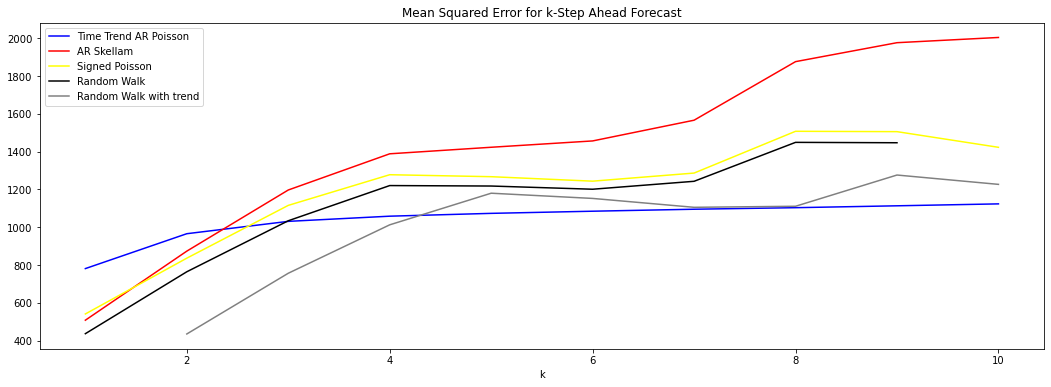

In [46]:
fig, ax = plt.subplots(figsize = (18,6))

mse_names = ['tt_mse','skel_mse','sign_mse','rw_mse','trend_rw_mse']
forecast_df[mse_names].plot(ax= ax, color = ['blue', 'red', 'yellow', 'black','gray'], title ='Mean Squared Error for k-Step Ahead Forecast')
ax.legend(['Time Trend AR Poisson', 'AR Skellam', 'Signed Poisson','Random Walk','Random Walk with trend'])

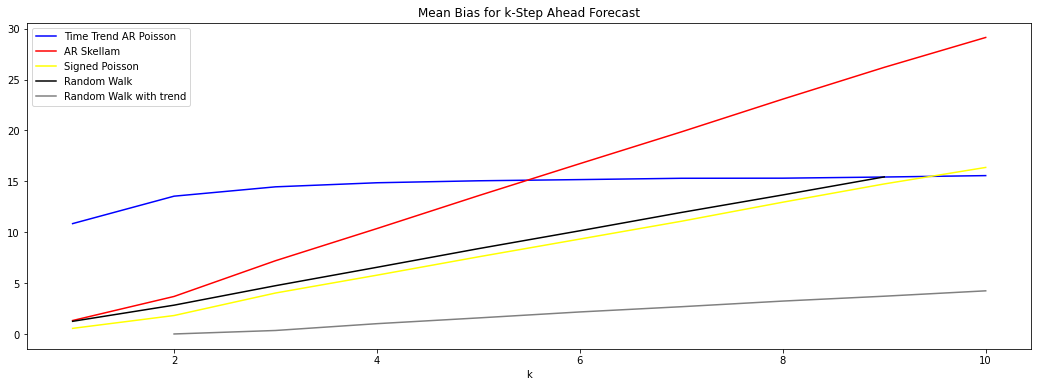

In [48]:
fig, ax = plt.subplots(figsize = (18,6))

bias_names = ['tt_bias','skel_bias','sign_bias','rw_bias','trend_rw_bias']
forecast_df[bias_names].plot(ax= ax, color = ['blue', 'red', 'yellow', 'black','gray'], title ='Mean Bias for k-Step Ahead Forecast')
ax.legend(['Time Trend AR Poisson', 'AR Skellam', 'Signed Poisson','Random Walk','Random Walk with trend'])

## Confidence Intervals

## 1 step ahead intervals

In [42]:
ci_cover_df = pd.DataFrame(columns = ['alpha','tt_ar_actual_coverage']).set_index('alpha')
grid_size = 20

#TT AR Poisson
for ci_alpha in np.linspace(0,1,grid_size):
    for index in tt_mle_df.index:
        ci = poisson.interval(ci_alpha, tt_mle_df.loc[index,'mean_est'])
        tt_mle_df.loc[index,'lower_ci'] = ci[0]
        tt_mle_df.loc[index,'upper_ci'] = ci[1]
        
    ci_cover_df.loc[ci_alpha, 'tt_ar_actual_coverage'] = len(tt_mle_df.query('Y > lower_ci & Y < upper_ci'))/len(tt_mle_df)

#Skellam
for ci_alpha in np.linspace(0,1,grid_size):
    for index in skellam_mle_df.index:
        ci = skellam(skellam_mle_df.loc[index, 'state1'], skellam_mle_df.loc[index,'state2']).interval(ci_alpha)
        skellam_mle_df.loc[index,'lower_ci'] = ci[0]
        skellam_mle_df.loc[index,'upper_ci'] = ci[1]
        
    ci_cover_df.loc[ci_alpha, 'skellam_actual_coverage'] = len(skellam_mle_df.query('obs > lower_ci & obs < upper_ci'))/len(skellam_mle_df)


#Signed AR Poisson
for ci_alpha in np.linspace(0,1,grid_size):
    signed_mle_df['lower_ci'] = signed_mle_df.apply(lambda s: signed_ar_ci(s[2],s[3], ci_alpha )[0]  , axis =1)
    signed_mle_df['upper_ci'] = signed_mle_df.apply(lambda s: signed_ar_ci(s[2],s[3], ci_alpha )[1]  , axis =1)

        
    ci_cover_df.loc[ci_alpha, 'signed_ar_actual_coverage'] = len(signed_mle_df.query('Y > lower_ci & Y < upper_ci'))/len(signed_mle_df)

    
    
ci_cover_df['Theoretical_Coverage'] = np.linspace(0,1,grid_size)
# ci_cover_df.plot(ax = ax)
# ax.legend(['Empirical Coverage','Theoretical Coverage'])

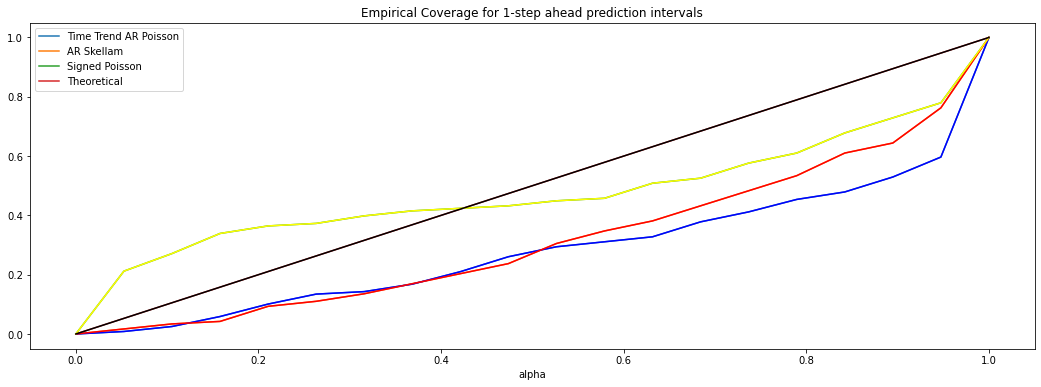

In [50]:
fig, ax = plt.subplots(figsize = (18,6))
ci_cover_df.plot(ax = ax)

ci_cover_df.plot(ax = ax,  color = ['blue', 'red', 'yellow','black'], title ='Empirical Coverage for 1-step ahead prediction intervals')
ax.legend(['Time Trend AR Poisson', 'AR Skellam', 'Signed Poisson', 'Theoretical'])

In [51]:
ci_length_df = pd.DataFrame(columns = ['alpha','tt_ar','skellam','signed','empirical']).set_index('alpha')
grid_size = 20

for ci_alpha in np.linspace(0,.99,grid_size):
    ci_length_df.loc[ci_alpha, 'tt_ar'] =  tt_mle_df['mean_est'].apply(lambda s:  poisson.interval(ci_alpha,s)[1]-poisson.interval(ci_alpha,s)[0] ).mean()
    ci_length_df.loc[ci_alpha, 'skellam'] = skellam_mle_df.apply(lambda s:  skellam(s[1],s[2]).interval(ci_alpha)[1]-skellam(s[1],s[2]).interval(ci_alpha)[0] , axis =1).mean()
    ci_length_df.loc[ci_alpha, 'signed'] =  signed_mle_df.apply(lambda s: signed_ar_ci(s[2],s[3], ci_alpha )[1] - signed_ar_ci(s[2],s[3], ci_alpha )[0]  , axis =1).mean()
    
    lower_quantile = (1-ci_alpha)/2
    upper_quantile = 1-lower_quantile
    ci_length_df.loc[ci_alpha,'empirical'] = delta_series.quantile(upper_quantile) - delta_series.quantile(lower_quantile)

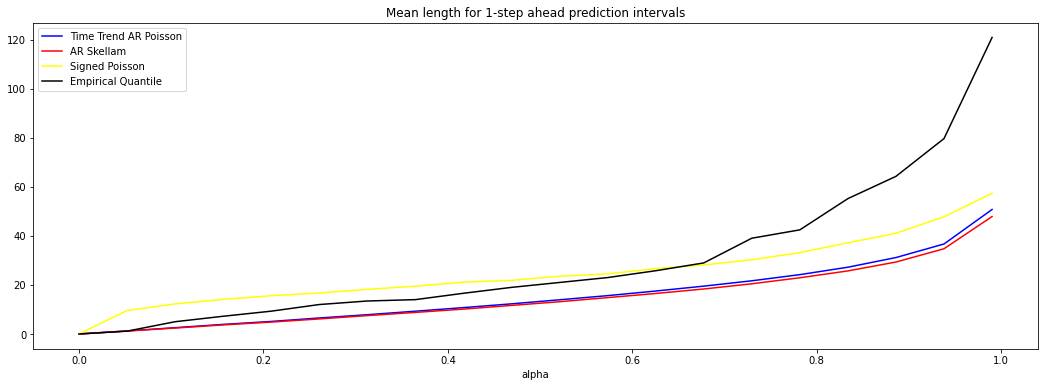

In [53]:
fig, ax = plt.subplots(figsize = (18,6))

ci_length_df.plot(ax = ax, color = ['blue', 'red', 'yellow','black'],  title ='Mean length for 1-step ahead prediction intervals')
ax.legend(['Time Trend AR Poisson', 'AR Skellam', 'Signed Poisson', 'Empirical Quantile'])

## Multi step intervals: Via simulation

In [43]:
def sim_time_trend(start_time, int_mean, k_ahead,sim_count, gamma, omega, alpha ,beta, coverage):
    Y_sim = []
    
    for sim in range(0, sim_count):
        new_y = np.random.poisson(int_mean)
        new_mean = gamma*start_time + omega + alpha*new_y + beta*int_mean
        
        for time in range(1,k_ahead):
            new_y = np.random.poisson(new_mean)
            new_mean = gamma *(start_time+time) + omega+alpha*new_y + beta*new_mean
        
        Y_sim.append(new_y)
    return [np.quantile(np.array(Y_sim), (1-coverage)/2.0), np.quantile(np.array(Y_sim),.5+.5*coverage)  ]

In [74]:
def sim_skellam(int_mean, k_ahead, sim_count, omega, alpha, beta,r, coverage):
    Y_sim = []
    
    for sim in range(0, sim_count):
        state_var = abs(int_mean/2.0)*(r+ np.array([np.sign(int_mean),-1.0*np.sign(int_mean)]))
        new_y = [skellam.rvs(state_var[0],state_var[1]) ]
        new_mean = omega + alpha*new_y[-1] + beta*int_mean
        
        for time in range(1, k_ahead):
            state_var = abs(new_mean/2.0)*(r+np.array([np.sign(new_mean),-1.0*np.sign(new_mean)]))
            new_y.append( skellam.rvs(state_var[0],state_var[1]) )
            new_mean = omega + alpha*new_y[-1] + beta*new_mean

        Y_sim.append(np.array(new_y).sum() )
    return [np.quantile(np.array(Y_sim), (1-coverage)/2.0), np.quantile(np.array(Y_sim),.5+.5*coverage)  ]

In [104]:
def sim_signed(int_mean, k_ahead, sim_count, omega, alpha, beta, sigsq, coverage):
    Y_sim = []
    
    for sim in range(0, sim_count):
        lam_var = -.5+.5*np.sqrt(4+sigsq+np.square(int_mean) )
        prob_var = .5*(1+(int_mean/lam_var))
        
        new_y = [ ( 2.0*(np.random.uniform()<prob_var)-1) * np.random.poisson(lam_var)]
        new_mean = omega + alpha*new_y[-1] + beta*int_mean
        
        for time in range(1, k_ahead):
            lam_var = -.5+.5*np.sqrt(4+sigsq+np.square(new_mean) )
            prob_var = .5*(1+(new_mean/lam_var))
            
            new_y.append(  ( 2.0*(np.random.uniform()<prob_var)-1) * np.random.poisson(lam_var) )
            new_mean = omega + alpha*new_y[-1] + beta*new_mean

        Y_sim.append(np.array(new_y).sum() )
    return [np.quantile(np.array(Y_sim), (1-coverage)/2.0), np.quantile(np.array(Y_sim),.5+.5*coverage)  ]           

# Appendix Models

### Model sign, fix lambda

In [187]:
def signed_ar_fix_lam(o,a,b,lam,ts):
    sample_size = len(ts)
    
    ll_value = 0
    sign_est = 0
    
    inf_status = 0
    
    for r in range(1,sample_size):
        new_y = ts[r]
        prob = .5*(1+sign_est)
        lam_state = lam
        
        obs_ll_value = np.log( signed_pmf(new_y, lam_state, prob)  )
        ll_value = ll_value + obs_ll_value
        sign_est =  o + a*np.sign(new_y) + b*sign_est

        if obs_ll_value < -500:
            inf_status =1

    if inf_status == 1:
        return 10000

    if inf_status == 0:
        return -ll_value

In [202]:
def signed_ar_fix_lam_filter(o,a,b,lam,ts):
    sample_size = len(ts)
    
    sign_est = [ 0 ]
    mean_est = [0]
    
    for r in range(1, sample_size):
        new_y = ts[r]
        new_sign =  o + a*np.sign(new_y) + b*sign_est[-1]
        sign_est.append(new_sign) 
        
        mean_est.append(lam * new_sign)

    filter_df = pd.DataFrame({'Y':ts,'mean':mean_est,'sign_est':sign_est})
    filter_df['lam'] = lam
    filter_df['prob'] = .5*(1+filter_df['sign_est'])
    
    filter_df[['mean','lam','prob','sign_est']] =filter_df[['mean','lam','prob','sign_est']].shift(1)
    filter_df = filter_df.dropna()
    return filter_df

In [215]:
delta_series = ts_df['delta'].dropna()

initial_guess = [0.5,.8,.1,12]
guess = initial_guess.copy()

for iteration in range(0,5):
    res_o = minimize_scalar( lambda o_hat : signed_ar_fix_lam(o_hat, guess[1], guess[2], guess[3], delta_series ), bounds = (-2,2),  method = 'bounded')
    guess[0] = res_o.x

    res_a = minimize_scalar( lambda a_hat : signed_ar_fix_lam(guess[0],a_hat, guess[2], guess[3],  delta_series ), bounds = (0,1-guess[2]), method = 'bounded')
    guess[1] = res_a.x

    res_b = minimize_scalar( lambda b_hat : signed_ar_fix_lam(guess[0], guess[1], b_hat, guess[3], delta_series ), bounds = (0, 1-guess[1]) , method = 'bounded')
    guess[2] = res_b.x
    
    res_l = minimize_scalar( lambda l_hat : signed_ar_fix_lam(guess[0], guess[1], guess[2], l_hat , delta_series ), bounds = (7,20), method = 'bounded')
    guess[3] = res_l.x


guess

<ipython-input-187-8c80b2e5b1de>:14: RuntimeWarning: invalid value encountered in log
  obs_ll_value = np.log( signed_pmf(new_y, lam_state, prob)  )


[0.08013730167467904,
 3.7765254894077407e-06,
 0.32980310419291925,
 15.144068081143347]

In [218]:
o,a,b,lam = guess
# a = .5

mle_df = signed_ar_fix_lam_filter(o,a,b,lam,delta_series)

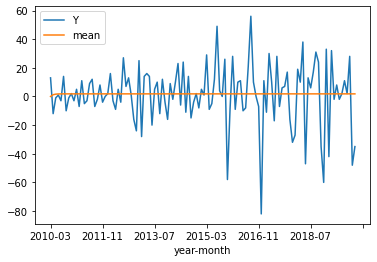

In [219]:
mle_df[['Y','mean']].plot()

In [295]:
o,a,b,lam = .1 ,0,0,15

mle_df = signed_ar_fix_lam_filter(o,a,b,lam,delta_series)

0.05084745762711865

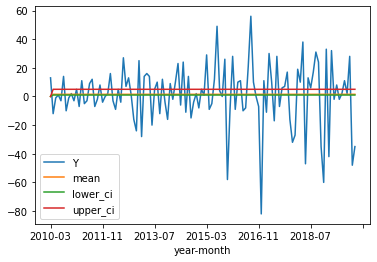

In [296]:
mle_df['lower_ci'] = mle_df.apply(lambda s: signed_ar_ci(s[2],s[3], .95 )[0]  , axis =1)
mle_df['upper_ci'] = mle_df.apply(lambda s: signed_ar_ci(s[2],s[3], .95 )[1]  , axis =1)

mle_df[['Y','mean','lower_ci','upper_ci']].plot()
len(mle_df.query('Y > lower_ci & Y < upper_ci'))/len(mle_df)

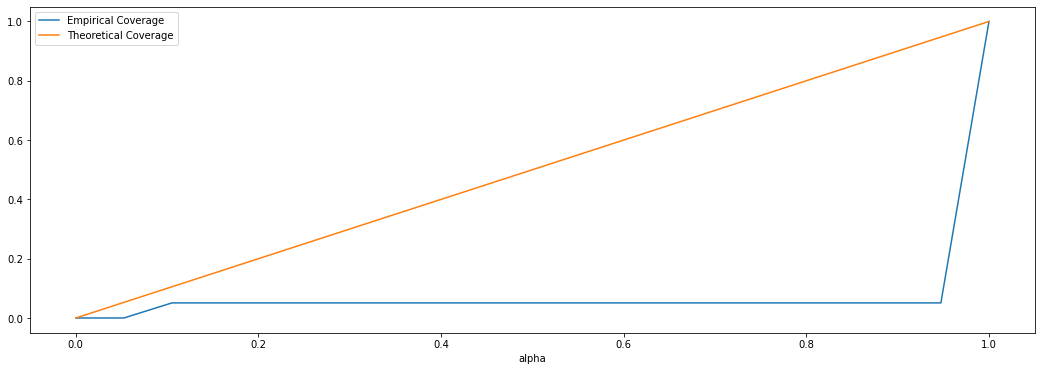

In [300]:
ci_cover_df = pd.DataFrame(columns = ['alpha','actual_coverage']).set_index('alpha')
grid_size = 20
fig, ax = plt.subplots(figsize = (18,6))


for ci_alpha in np.linspace(0,1,grid_size):
    mle_df['lower_ci'] = mle_df.apply(lambda s: signed_ar_ci(s[2],s[3], ci_alpha )[0]  , axis =1)
    mle_df['upper_ci'] = mle_df.apply(lambda s: signed_ar_ci(s[2],s[3], ci_alpha )[1]  , axis =1)

        
    ci_cover_df.loc[ci_alpha, 'actual_coverage'] = len(mle_df.query('Y > lower_ci & Y < upper_ci'))/len(mle_df)
    
ci_cover_df['Theoretical_Coverage'] = np.linspace(0,1,grid_size)
ci_cover_df.plot(ax = ax)
ax.legend(['Empirical Coverage','Theoretical Coverage'])